In this notebook, the lumped elements circuit unknowns are optimized against the measurement, to find short length and resistances that fit the best measured S11. Once fitted, voltages and currents are displayed against various parameters 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tresonator as T

## S11 vs Frequency 

In [3]:
fs = 1e6*np.linspace(61, 64, 301)
P_in = 20e3 # W

@interact(Lsc_DUT=(20, 60, 0.1), Lsc_CEA=(1, 200, 0.1), 
          Z_DUT=(1, 1e2, 0.1), Z_CEA=(1, 1e2, 0.1), 
          add_loss=(0.1, 5, 0.1))
def S11_vf_f(Lsc_DUT=33, Lsc_CEA=32, 
             Z_DUT = 6, Z_CEA = 6,
             add_loss=1.0):
    S11dB = []
    for f in fs:
        _cfg = T.Configuration(f, P_in, Lsc_DUT*1e-3, Lsc_CEA*1e-3, 
                               Z_short_DUT = Z_DUT*1e-3, Z_short_CEA = Z_CEA*1e-3, 
                               additional_losses=add_loss)
        S11dB.append(_cfg.S11dB())
    fig,ax=plt.subplots()
    ax.plot(fs/1e6, S11dB, lw=2)
    ax.grid(True)
    ax.set_ylim(-40,0)
    ax.set_xlabel('f [MHz]', fontsize=14)
    ax.set_ylabel('S11 [dB]', fontsize=14)

interactive(children=(FloatSlider(value=33.0, description='Lsc_DUT', max=60.0, min=20.0), FloatSlider(value=32…

## Map of the short lengths

In [4]:
def S11_from_Ls(f, L_DUT, L_CEA, add_loss=1.0, P_in=1):
    _cfg = T.Configuration(f, P_in, L_DUT, L_CEA, additional_losses=add_loss, 
                           Z_short_CEA=6.8e-3, Z_short_DUT=6.7e-3)
    return _cfg.S11dB()

S11dB_vec = np.vectorize(S11_from_Ls)

In [5]:
L_DUTs = np.linspace(10e-3, 35e-3, 100)
L_CEAs = np.linspace(10e-3, 140e-3, 100)

LL_DUTs, LL_CEAs = np.meshgrid(L_DUTs, L_CEAs)

@interact(f=(60, 65, 0.1))
def plot_2D(f=62.64):
    S11dB = S11dB_vec(f*1e6, LL_DUTs, LL_CEAs, add_loss=1.0)
    fig,ax=plt.subplots()
    c=ax.pcolor(LL_DUTs*1e3, LL_CEAs*1e3, S11dB, vmin=-40, vmax=0, cmap='Greens_r')
    plt.colorbar(c)
    ax.set_xlabel('L DUT [mm]', fontsize=14)
    ax.set_ylabel('L CEA [mm]', fontsize=14)

interactive(children=(FloatSlider(value=62.64, description='f', max=65.0, min=60.0), Output()), _dom_classes=(…

## Optimizing from S11 measurements

In [6]:
filename = 'data/RES2.ASC'

exp_freq,reS11,imS11 = np.loadtxt(filename, skiprows=14, delimiter=';', unpack=True)

exp_mag = np.sqrt(reS11**2 + imS11**2)
exp_mag_dB = 20*np.log10(exp_mag)
# find the match frequency 
exp_freq_match = exp_freq[np.argmin(exp_mag)]
print('Match frequency : {} MHz'.format(exp_freq_match/1e6))

Match frequency : 62.640625 MHz


In [7]:
def optim_fun_impedance(short_properties):
    L_DUT, Z_DUT, L_CEA, Z_CEA, add_loss = short_properties
    # calculates the resonator S11 vs freq
    S11dB = []
    for f in exp_freq:
        _cfg = T.Configuration(f, P_in=1, L_DUT=L_DUT, L_CEA=L_CEA, 
                               Z_short_DUT=Z_DUT, Z_short_CEA=Z_CEA, 
                               additional_losses=add_loss)
        S11dB.append(_cfg.S11dB())
    
    crit = np.sum( (np.array(S11dB) - exp_mag_dB)**2) #least square 
    print(short_properties, crit)
    return crit  

In [8]:
d_DUT_0 = 0.035 # m
d_CEA_0 = 0.035 # m
Z_DUT_0 = 0.01 # Ohm
Z_CEA_0 = 0.01 # Ohm
add_loss = 1.0

bounds_pties = ((20e-3, 63e-3), (1e-3, 1), # d,Z DUT
                (5e-3, 200e-3), (1e-3, 1), # d,Z CEA
                (0.1, 2)) # add losses

opt_res = minimize(optim_fun_impedance, (d_DUT_0, Z_DUT_0, d_CEA_0, Z_CEA_0, add_loss),
                  bounds=bounds_pties)

[0.035 0.01  0.035 0.01  1.   ] 9956.686465532102
[0.03500001 0.01       0.035      0.01       1.        ] 9956.702965904995
[0.035      0.01000001 0.035      0.01       1.        ] 9956.684455598182
[0.035      0.01       0.03500001 0.01       1.        ] 9956.687130777014
[0.035      0.01       0.035      0.01000001 1.        ] 9956.68555547423
[0.035      0.01       0.035      0.01       1.00000001] 9956.686416454628
[0.02  1.    0.005 1.    2.   ] 6430.982456966881
[0.02000001 1.         0.005      1.         2.        ] 6430.982422324432
[0.02       0.99999999 0.005      1.         2.        ] 6430.982456548172
[0.02       1.         0.00500001 1.         2.        ] 6430.982443633074
[0.02       1.         0.005      0.99999999 2.        ] 6430.98245594576
[0.02       1.         0.005      1.         1.99999999] 6430.982456923171
[0.02024813 1.         0.00512956 1.         2.        ] 6429.953005427562
[0.02024814 1.         0.00512956 1.         2.        ] 6429.952971247703
[0

[0.03931446 0.09282881 0.08048006 0.09473161 0.82755104] 7106.887615079389
[0.03931446 0.09282881 0.08048005 0.09473162 0.82755104] 7106.887614973939
[0.03931446 0.09282881 0.08048005 0.09473161 0.82755105] 7106.8876231841
[0.03182913 0.12184942 0.04270823 0.12435356 1.05747863] 5934.231732122874
[0.03182914 0.12184942 0.04270823 0.12435356 1.05747863] 5934.233073412409
[0.03182913 0.12184943 0.04270823 0.12435356 1.05747863] 5934.231762135775
[0.03182913 0.12184942 0.04270824 0.12435356 1.05747863] 5934.232777146182
[0.03182913 0.12184942 0.04270823 0.12435357 1.05747863] 5934.231730531351
[0.03182913 0.12184942 0.04270823 0.12435356 1.05747864] 5934.231732228429
[0.03075468 0.12601507 0.03728641 0.12860553 1.09048274] 5515.9470590022065
[0.03075469 0.12601507 0.03728641 0.12860553 1.09048274] 5515.945697752119
[0.03075468 0.12601508 0.03728641 0.12860553 1.09048274] 5515.94711088552
[0.03075468 0.12601507 0.03728642 0.12860553 1.09048274] 5515.947323255922
[0.03075468 0.12601507 0.03

[0.03663391 0.001      0.02274007 0.00483506 0.94328946] 2118.447407728006
[0.03267464 0.001      0.0335701  0.00430905 0.95346048] 392.13240031012407
[0.03267465 0.001      0.0335701  0.00430905 0.95346048] 392.11785015390444
[0.03267464 0.00100001 0.0335701  0.00430905 0.95346048] 392.1308830368777
[0.03267464 0.001      0.03357011 0.00430905 0.95346048] 392.1254874182048
[0.03267464 0.001      0.0335701  0.00430906 0.95346048] 392.1317716872169
[0.03267464 0.001      0.0335701  0.00430905 0.95346049] 392.13236568950913
[0.063 1.    0.005 1.    2.   ] 8635.860155471053
[0.06299999 1.         0.005      1.         2.        ] 8635.858716545059
[0.063      0.99999999 0.005      1.         2.        ] 8635.860169176724
[0.063      1.         0.00500001 1.         2.        ] 8635.859609179057
[0.063      1.         0.005      0.99999999 2.        ] 8635.860159412849
[0.063      1.         0.005      1.         1.99999999] 8635.860155709954
[0.04221715 0.31535613 0.02457992 0.31762392 1.

[0.03302091 0.00313488 0.03262287 0.00647762 0.9550582 ] 173.80674042630395
[0.0330209  0.00313489 0.03262287 0.00647762 0.9550582 ] 173.76738999827523
[0.0330209  0.00313488 0.03262288 0.00647762 0.9550582 ] 173.78272304723956
[0.0330209  0.00313488 0.03262287 0.00647763 0.9550582 ] 173.7663892371221
[0.0330209  0.00313488 0.03262287 0.00647762 0.95505821] 173.76576335643892
[0.03307211 0.00318059 0.03247812 0.00653156 0.95449475] 162.89666821408076
[0.03307212 0.00318059 0.03247812 0.00653156 0.95449475] 162.90402742070626
[0.03307211 0.0031806  0.03247812 0.00653156 0.95449475] 162.89658864085186
[0.03307211 0.00318059 0.03247813 0.00653156 0.95449475] 162.899176971518
[0.03307211 0.00318059 0.03247812 0.00653157 0.95449475] 162.89662668686887
[0.03307211 0.00318059 0.03247812 0.00653156 0.95449476] 162.8966660453631
[0.03324491 0.00373401 0.03198244 0.00710821 0.95381066] 161.23110129908088
[0.03324492 0.00373401 0.03198244 0.00710821 0.95381066] 161.23422915942902
[0.03324491 0.00

[0.0330979  0.00342427 0.0323879  0.00677915 0.9542985 ] 159.82330163400528
[0.0330979  0.00342426 0.03238791 0.00677915 0.9542985 ] 159.82344880327352
[0.0330979  0.00342426 0.0323879  0.00677916 0.9542985 ] 159.8233020704456
[0.0330979  0.00342426 0.0323879  0.00677915 0.95429851] 159.82330297977035
[0.0330979  0.00342426 0.0323879  0.00677915 0.9542985 ] 159.82330302761704
[0.03309791 0.00342426 0.0323879  0.00677915 0.9542985 ] 159.82372328432962
[0.0330979  0.00342427 0.0323879  0.00677915 0.9542985 ] 159.8233016337176
[0.0330979  0.00342426 0.03238791 0.00677915 0.9542985 ] 159.82344880299942
[0.0330979  0.00342426 0.0323879  0.00677916 0.9542985 ] 159.82330207015332
[0.0330979  0.00342426 0.0323879  0.00677915 0.95429851] 159.82330297947067
[0.0330979  0.00342426 0.0323879  0.00677915 0.9542985 ] 159.82330302755526
[0.03309791 0.00342426 0.0323879  0.00677915 0.9542985 ] 159.82372328428846
[0.0330979  0.00342427 0.0323879  0.00677915 0.9542985 ] 159.82330163366035
[0.0330979  0.

[0.03309772 0.00344537 0.03238737 0.00680018 0.95432064] 159.81443993270557
[0.03309772 0.00344537 0.03238736 0.00680019 0.95432064] 159.81444134871012
[0.03309772 0.00344537 0.03238736 0.00680018 0.95432065] 159.81444134959773
[0.03309772 0.00344533 0.03238736 0.00680014 0.9543206 ] 159.81443979330066
[0.03309773 0.00344533 0.03238736 0.00680014 0.9543206 ] 159.81444613617015
[0.03309772 0.00344534 0.03238736 0.00680014 0.9543206 ] 159.8144395928997
[0.03309772 0.00344533 0.03238737 0.00680014 0.9543206 ] 159.81443859763988
[0.03309772 0.00344533 0.03238736 0.00680015 0.9543206 ] 159.8144397888766
[0.03309772 0.00344533 0.03238736 0.00680014 0.95432061] 159.81443979131586
[0.03309772 0.00344533 0.03238736 0.00680014 0.9543206 ] 159.81443969442324
[0.03309773 0.00344533 0.03238736 0.00680014 0.9543206 ] 159.8144460778222
[0.03309772 0.00344534 0.03238736 0.00680014 0.9543206 ] 159.81443949388586
[0.03309772 0.00344533 0.03238737 0.00680014 0.9543206 ] 159.81443851316448
[0.03309772 0.0

[0.03309772 0.00344539 0.03238737 0.00680017 0.95432061] 159.81444192534823
[0.03309772 0.00344539 0.03238737 0.00680016 0.95432062] 159.81444176752984
[0.03309772 0.00344535 0.03238737 0.00680015 0.9543206 ] 159.81443842537414
[0.03309773 0.00344535 0.03238737 0.00680015 0.9543206 ] 159.81446243426967
[0.03309772 0.00344536 0.03238737 0.00680015 0.9543206 ] 159.81443842423957
[0.03309772 0.00344535 0.03238738 0.00680015 0.9543206 ] 159.8144437432593
[0.03309772 0.00344535 0.03238737 0.00680016 0.9543206 ] 159.81443848733602
[0.03309772 0.00344535 0.03238737 0.00680015 0.95432061] 159.81443842726816
[0.03309772 0.00344534 0.03238736 0.00680014 0.9543206 ] 159.81443879869505
[0.03309773 0.00344534 0.03238736 0.00680014 0.9543206 ] 159.8144530202519
[0.03309772 0.00344535 0.03238736 0.00680014 0.9543206 ] 159.81443868680682
[0.03309772 0.00344534 0.03238737 0.00680014 0.9543206 ] 159.814440507622
[0.03309772 0.00344534 0.03238736 0.00680015 0.9543206 ] 159.81443882372284
[0.03309772 0.00

In [14]:
P_in = 20e3 # W

S11dB = []
L_DUT_opt, Z_DUT_opt, L_CEA_opt, Z_CEA_opt, add_loss_opt = opt_res.x
print(f'Optimization Result: L_DUT_opt={L_DUT_opt:.3}, Z_DUT_opt={Z_DUT_opt:.3},',
      f'L_CEA_opt={L_CEA_opt:.3}, Z_CEA_opt={Z_CEA_opt:.3}, add_loss_opt={add_loss_opt:.3}')

Optimization Result: L_DUT_opt=0.0331, Z_DUT_opt=0.00345, L_CEA_opt=0.0324, Z_CEA_opt=0.0068, add_loss_opt=0.954


[0.03309772 0.00344534 0.03238736 0.00680014 0.9543206 ]


Text(0, 0.5, 'S11 [dB]')

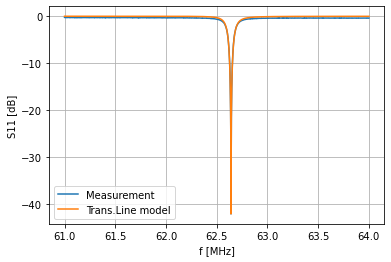

In [9]:
for f in exp_freq:
    _cfg = T.Configuration(f, P_in, L_DUT_opt, L_CEA_opt, 
                           Z_short_DUT = Z_DUT_opt, Z_short_CEA = Z_CEA_opt, 
                           additional_losses=add_loss_opt)
    S11dB.append(_cfg.S11dB())

fig,ax=plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB)
ax.plot(exp_freq/1e6, S11dB)
ax.legend(('Measurement', 'Trans.Line model'))
plt.grid(True)
ax.set_xlabel('f [MHz]')
ax.set_ylabel('S11 [dB]')

[0.03309772 0.00344534 0.03238736 0.00680014 0.9543206 ]


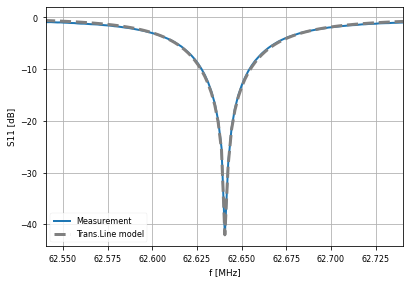

In [10]:
plt.style.use('seaborn-paper')
fig,ax=plt.subplots()
ax.plot(exp_freq/1e6, exp_mag_dB, lw=2)
ax.plot(exp_freq/1e6, S11dB, lw=3, color="grey", ls='--')
ax.legend(('Measurement', 'Trans.Line model'))
ax.set_xlim(exp_freq_match/1e6-0.1, exp_freq_match/1e6+0.1)
plt.grid(True)
ax.set_xlabel('f [MHz]')
ax.set_ylabel('S11 [dB]')
print(opt_res.x)

## Voltage and current in the resonator at matching point

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


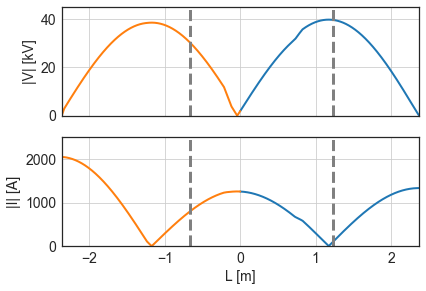

In [11]:
plt.style.use('seaborn-white')

P_in=60e3 # W

cfg_opt = T.Configuration(exp_freq_match, P_in, L_DUT_opt, L_CEA_opt, 
                           Z_short_DUT = Z_DUT_opt, Z_short_CEA = Z_CEA_opt, 
                           additional_losses=add_loss_opt)

# Calculates the voltage and current along the transmission lines
L_CEA, L_DUT, V_CEA, V_DUT, I_CEA, I_DUT = cfg_opt.voltage_current();

# Plotting V,I
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(L_CEA, np.abs(V_CEA)/1e3,-L_DUT, np.abs(V_DUT)/1e3,  lw=2)
ax[0].set_ylim(0, 45)
ax[0].grid(True)
ax[0].set_xlim(min(-L_DUT), max(L_CEA))
ax[0].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[0].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[0].set_ylabel('|V| [kV]', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(L_CEA, np.abs(I_CEA),-L_DUT, np.abs(I_DUT),  lw=2)
ax[1].set_ylim(0, 2500)
ax[1].grid(True)
ax[1].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[1].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[1].set_xlabel('L [m]', fontsize=14)
ax[1].set_ylabel('|I| [A]', fontsize=14)
ax[1].tick_params(labelsize=14)

# Voltage, Current and Characteristic Impedance

In [12]:
# generating arrays of location of the various char impedance sections
Zc = [0]
le = [0]
re = [0]
Ls = [0]
for TL in cfg_opt.TLs:
    Zc.append(TL.Zc)
    # left edge
    le.append(re[-1])
    # right edge
    re.append(re[-1] + TL.L)
    Ls.append(TL.L)

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 45, '49.9')

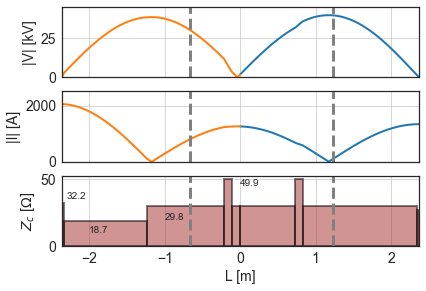

In [13]:
plt.style.use('seaborn-paper')

P_in=60e3 # W

cfg_opt = T.Configuration(exp_freq_match, P_in, L_DUT_opt, L_CEA_opt, 
                           Z_short_DUT = Z_DUT_opt, Z_short_CEA = Z_CEA_opt, 
                           additional_losses=add_loss_opt)

# Calculates the voltage and current along the transmission lines
L_CEA, L_DUT, V_CEA, V_DUT, I_CEA, I_DUT = cfg_opt.voltage_current();

# Plotting V,I
fig, ax = plt.subplots(3,1, sharex=True)
ax[0].plot(L_CEA, np.abs(V_CEA)/1e3,-L_DUT, np.abs(V_DUT)/1e3,  lw=2)
ax[0].set_ylim(0, 45)
ax[0].grid(True)
ax[0].set_xlim(min(-L_DUT), max(L_CEA))
ax[0].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[0].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[0].set_ylabel('|V| [kV]', fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(L_CEA, np.abs(I_CEA),-L_DUT, np.abs(I_DUT),  lw=2)
ax[1].set_ylim(0, 2500)
ax[1].grid(True)
ax[1].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[1].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[1].set_ylabel('|I| [A]', fontsize=14)
ax[1].tick_params(labelsize=14)

ax[2].bar(le-max(L_DUT), Zc, width=Ls,  lw=2, align='edge', color='brown', alpha=0.5, edgecolor='k')
ax[2].set_xlim(-max(L_DUT), max(L_CEA))
ax[2].grid(True)
ax[2].axvline(x=cfg_opt.L_Vprobe_CEA_fromT, ls='--', color='gray', lw=3)
ax[2].axvline(x=-cfg_opt.L_Vprobe_DUT_fromT, ls='--', color='gray', lw=3)
ax[2].set_ylabel('$Z_c$ [$\Omega$]', fontsize=14)
ax[2].tick_params(labelsize=14)
ax[2].set_xlabel('L [m]', fontsize=14)

ax[2].text(-2.3, 35, round(Zc[1],1))
ax[2].text(-2, 10, round(Zc[2],1))
ax[2].text(-1, 20, round(Zc[3],1))
ax[2].text(0, 45, round(Zc[4],1))

#fig.savefig('SSA50_voltage_current_config_60kW_f62.64MHz.png', dpi=300)